<a href="https://colab.research.google.com/github/jordanco-bgu/social_network_movies/blob/main/Movie_success_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Networks of a Movie as Predictors of Box Office Success

Analyzing the box office success of movies based on attributes of the social networks within the movie.


In [1]:
!pip install statsmodels
!pip install scikit-posthocs

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.stats import kruskal
from scipy.stats import shapiro
import seaborn as sns
from scikit_posthocs import posthoc_dunn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
social_attributes_df = pd.read_csv('./drive/MyDrive/social_network_attributes_dataset.csv').drop('Unnamed: 0', axis=1)
movie_info_df = pd.read_csv('./drive/MyDrive/movie_information_dataset.csv').drop('Unnamed: 0', axis=1)

box_office_success_df = pd.merge(social_attributes_df, movie_info_df, left_on='movie_name', right_on='Title', how='inner').drop('Title', axis=1)
box_office_success_df = box_office_success_df.dropna(subset=['Budget', 'Revenue', 'Rating'])
box_office_success_df['Budget'] = box_office_success_df['Budget'].apply(lambda x: int(re.sub("[^0-9\.]", "", x)) if (type(x) is str) else 0)
box_office_success_df['Revenue'] = box_office_success_df['Revenue'].apply(lambda x: int(re.sub("[^0-9\.]", "", x)) if (type(x) is str) else 0)
box_office_success_df

,movie_name,year,num_characters,num_connections,num_connected_components,num_main_characters,max_degree_node_value,max_degree_node,network_strength,max_weight_edge_value,max_weight_edge_source,max_weight_edge_target,Budget,Revenue,Rating
0,The Night Flier,1997,11,17,2,1,6,Richard Dees,235,59,Richard Dees,Katherine 'Jimmy' Blair,1000000,125397,6.0
2,Final Destination 2,2003,16,58,1,5,14,Kimberly Corman,512,27,Kimberly Corman,Clear Rivers,26000000,90941129,6.2
3,Resurrecting the Champ,2007,24,103,1,4,21,Bob Satterfield Jr.,1260,69,Bob Satterfield Jr.,Erik 'The Wow Man' Kernan Sr.,13000000,3243611,6.7
4,John Wick: Chapter 2,2017,17,26,1,1,15,John Wick,313,73,John Wick,Santino D'Antonio,40000000,174348632,7.4
5,Skyline,2010,7,13,1,4,5,Jarrod,207,57,Jarrod,Terry,10000000,66984887,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,Snow Dogs,2002,16,30,1,2,12,Ted Brooks,256,29,Ted Brooks,James 'Thunder Jack' Johnson,33000000,115035090,5.2
12656,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2
12657,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2
12658,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2


In this study, we have decided to define a successful movie as one that is successful in both profit and in rating. A successful rating is considered one that is greater than or equal to 7.5. The rating system is according to the one used by IMDb. In terms of profit, a successful movie is one that made at least twice its budget. If a movie meets both of these conditions, it is considered successful. If a movie meets only one of these conditions, it is considered partially successful. And if a movie meets neither of these conditions, it is considered a failure.

In [5]:
def determine_success(row):
  is_rating_success = False
  is_profit_success = False
  determination = 'failure'

  if (row['Rating'] >= 7.5):
    is_rating_success = True
  if ((row['Budget'] != 0) and (row['Revenue'] / row['Budget']) >= 2):
    is_profit_success = True

  if (is_rating_success and is_profit_success):
    determination = 'success'
  elif (is_rating_success or is_profit_success):
    determination = 'partial'

  return determination

box_office_success_df['Success'] = box_office_success_df.apply(determine_success, axis=1)
box_office_success_df

,movie_name,year,num_characters,num_connections,num_connected_components,num_main_characters,max_degree_node_value,max_degree_node,network_strength,max_weight_edge_value,max_weight_edge_source,max_weight_edge_target,Budget,Revenue,Rating,Success
0,The Night Flier,1997,11,17,2,1,6,Richard Dees,235,59,Richard Dees,Katherine 'Jimmy' Blair,1000000,125397,6.0,failure
2,Final Destination 2,2003,16,58,1,5,14,Kimberly Corman,512,27,Kimberly Corman,Clear Rivers,26000000,90941129,6.2,partial
3,Resurrecting the Champ,2007,24,103,1,4,21,Bob Satterfield Jr.,1260,69,Bob Satterfield Jr.,Erik 'The Wow Man' Kernan Sr.,13000000,3243611,6.7,failure
4,John Wick: Chapter 2,2017,17,26,1,1,15,John Wick,313,73,John Wick,Santino D'Antonio,40000000,174348632,7.4,partial
5,Skyline,2010,7,13,1,4,5,Jarrod,207,57,Jarrod,Terry,10000000,66984887,4.5,partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,Snow Dogs,2002,16,30,1,2,12,Ted Brooks,256,29,Ted Brooks,James 'Thunder Jack' Johnson,33000000,115035090,5.2,partial
12656,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2,failure
12657,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2,failure
12658,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2,failure


## Testing for Normality of the Data

Number of Characters:
Shapiro-Wilk Test Statistic: 0.9198001027107239
P-value: 0.0
The data is not normally distributed.




/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


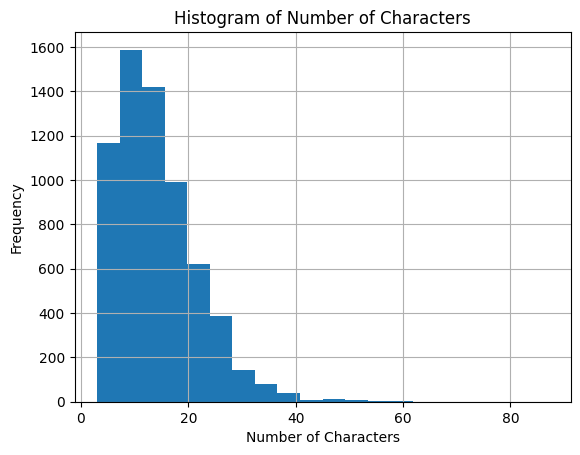

Network Closeness:
Shapiro-Wilk Test Statistic: 0.7317579388618469
P-value: 0.0
The data is not normally distributed.




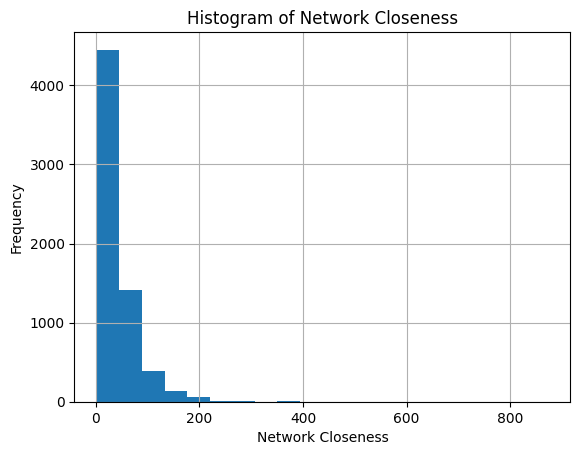

Number of Connected Components:
Shapiro-Wilk Test Statistic: 0.22052603960037231
P-value: 0.0
The data is not normally distributed.




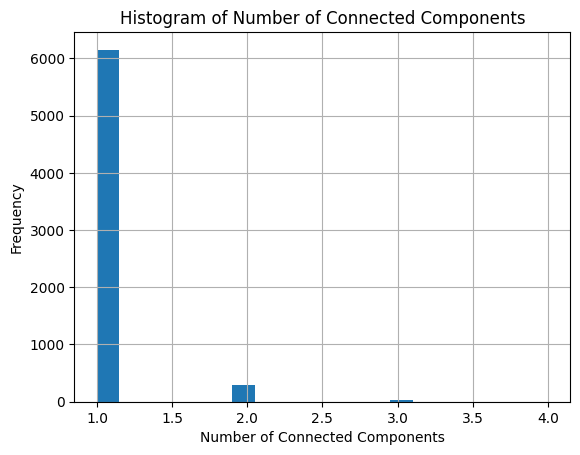

Number of Main Characters:
Shapiro-Wilk Test Statistic: 0.8800495862960815
P-value: 0.0
The data is not normally distributed.




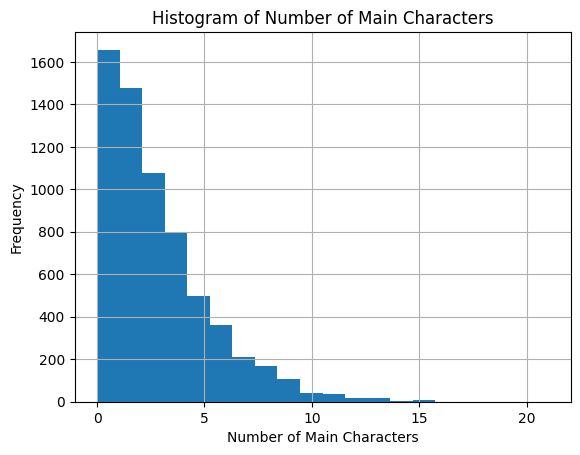

Network Strength:
Shapiro-Wilk Test Statistic: 0.6014667749404907
P-value: 0.0
The data is not normally distributed.




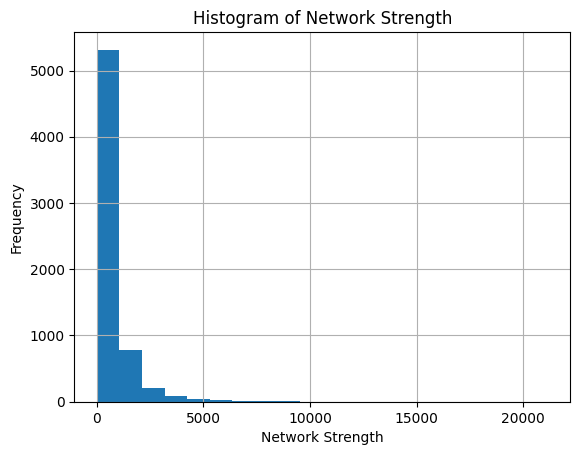

In [6]:
def determine_data_normality(data):
  statistic, p_value = shapiro(data)

  print("Shapiro-Wilk Test Statistic:", statistic)
  print("P-value:", p_value)

  if p_value < 0.05:
    print("The data is not normally distributed.")
  else:
    print("The data is normally distributed.")

  print("\n")

# num_characters
print('Number of Characters:')
determine_data_normality(box_office_success_df['num_characters'])
box_office_success_df['num_characters'].hist(bins=20)
plt.title('Histogram of Number of Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# num_connections
print('Network Closeness:')
determine_data_normality(box_office_success_df['num_connections'])
box_office_success_df['num_connections'].hist(bins=20)
plt.title('Histogram of Network Closeness')
plt.xlabel('Network Closeness')
plt.ylabel('Frequency')
plt.show()

# num_connected_components
print('Number of Connected Components:')
determine_data_normality(box_office_success_df['num_connected_components'])
box_office_success_df['num_connected_components'].hist(bins=20)
plt.title('Histogram of Number of Connected Components')
plt.xlabel('Number of Connected Components')
plt.ylabel('Frequency')
plt.show()

# num_main_characters
print('Number of Main Characters:')
determine_data_normality(box_office_success_df['num_main_characters'])
box_office_success_df['num_main_characters'].hist(bins=20)
plt.title('Histogram of Number of Main Characters')
plt.xlabel('Number of Main Characters')
plt.ylabel('Frequency')
plt.show()

# network_strength
print('Network Strength:')
determine_data_normality(box_office_success_df['network_strength'])
box_office_success_df['network_strength'].hist(bins=20)
plt.title('Histogram of Network Strength')
plt.xlabel('Network Strength')
plt.ylabel('Frequency')
plt.show()


We use the Shapiro-Wilk test for normality in order to determine if the data for the different attributes (such as number of characters, number of connections, etc) is normally distributed. If the p-value for the Shapiro-Wilk Test is less than 0.05, the data is not normally distributed.

The shape of the distribution will determine the type of statistical analysis we are able to perform. If the data were normally distributed, we would be able to perform an ANOVA (analysis of variance) test in order to understand if the differences between movies that failed, partially succeeded, or succeeded are statistically significant. Because the data is not normally distributed, we perform the Kruskal-Wallis Test instead.

## Analysis of the Effects of Individual Attributes on Movie Success

First, we decided to analyze the effect of the individual attributes (such as number of characters, network strength, etc) on movie success in order to determine if there were individual attributes that were strong enough to affect the outcome by themselves.

The average numbers for each success category (failure, partial success, success) for the attributes examined are shown in bar graphs. Boxplots for some of the attribute analyses were also created in order to show the general distribution of the points and to make note of any outliers.

For each of the following attribute analyses, the Kruskal-Willis Test was performed (the non-parametric equivalent of the ANOVA test) in order to determine if there was a significant difference between the data of movies that failed, that were partially successful, or were successful. If the p-value returned by this test was less than 0.05, then there was a statistically significant difference between at least two of the datasets. If this was the case, then a Dunn-Bonferroni Post-hoc was performed in order to determine which pairs of the datasets were significantly different from each other.

A statistically significant difference between two (or more) of the datasets indicates that it is possible to draw a conclusion about the value of the attribute examined and its effect on the success of a movie.

### The Effect of the Number of Connected Components of a Movie Network on Movie Success

In [7]:
connected_components_df = box_office_success_df.groupby('Success')['num_connected_components'].mean()
print(connected_components_df)

Success
failure    1.058931
partial    1.052486
success    1.051084
Name: num_connected_components, dtype: float64


Because the data of number of connected components is not normally distributed according to the Shapiro-Wilk Test, we can test for statistical significance of this variable using the Kruskal-Willis Test.

In [8]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['num_connected_components']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['num_connected_components']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['num_connected_components']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

Kruskal-Wallis Test Statistic: 1.1394511479138043
P-value: 0.5656806549046611
There is no statistically significant difference between the columns.


### The Effect of the Number of Characters (Number of Nodes) on Movie Success

Success
failure    13.044957
partial    14.567877
success    17.636223
Name: num_characters, dtype: float64


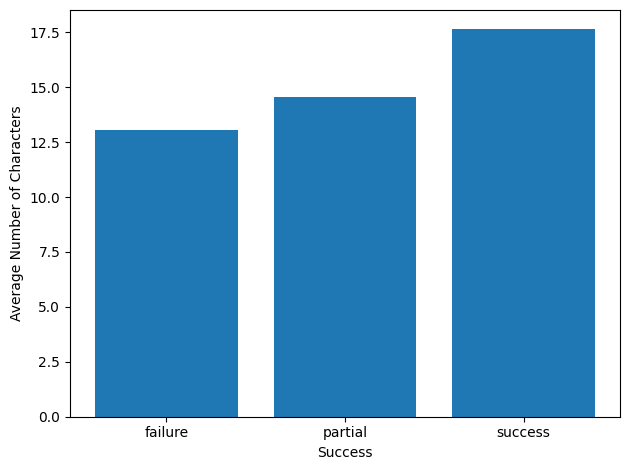

In [9]:
num_characters_df = box_office_success_df.groupby('Success')['num_characters'].mean()
print(num_characters_df)
plt.bar(num_characters_df.index, num_characters_df.values)

plt.xlabel('Success')
plt.ylabel('Average Number of Characters')
plt.tight_layout()
plt.show()

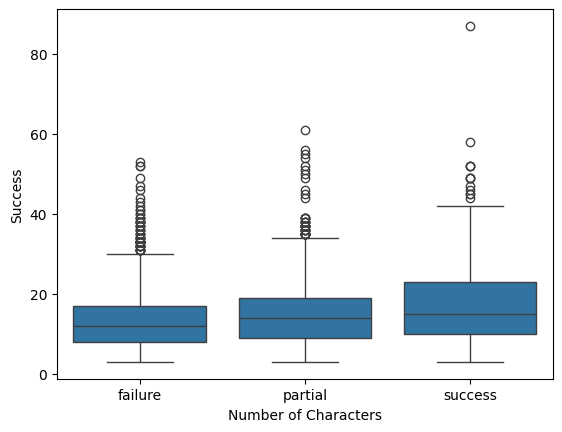

In [10]:
sns.boxplot(x='Success', y='num_characters', data=box_office_success_df)
plt.xlabel('Number of Characters')
plt.ylabel('Success')
plt.show()

In [11]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['num_characters']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['num_characters']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['num_characters']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

data = [failure, partial, success]
p_values = posthoc_dunn(data, p_adjust='bonferroni')

print("Matrix of pairwise p-values:")
print(p_values)

Kruskal-Wallis Test Statistic: 155.1594525131764
P-value: 2.0302661751249917e-34
There is a statistically significant difference between at least one pair of columns.
Matrix of pairwise p-values:
              1             2             3
1  1.000000e+00  8.169179e-17  5.171507e-28
2  8.169179e-17  1.000000e+00  2.870294e-08
3  5.171507e-28  2.870294e-08  1.000000e+00


As can be seen from the matrix of p-values for the comparison between number of characters in successful, partially successful, and failing movies, there is a significant difference between all pairs of the different groupings. Meaning, that the number of characters in a movie has a significant effect on the success or failure of a movie, with the trend indicating that the more characters in a movie, the more likely it is to be successful.

### The Effect of the Closeness of a Movie Network (Number of Edges) on Movie Success

Success
failure    34.783414
partial    43.081689
success    64.236842
Name: num_connections, dtype: float64


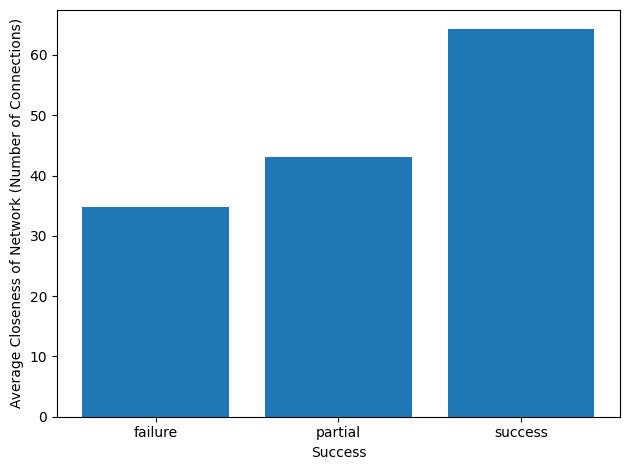

In [12]:
num_edges_df = box_office_success_df.groupby('Success')['num_connections'].mean()
print(num_edges_df)
plt.bar(num_edges_df.index, num_edges_df.values)

plt.xlabel('Success')
plt.ylabel('Average Closeness of Network (Number of Connections)')
plt.tight_layout()
plt.show()

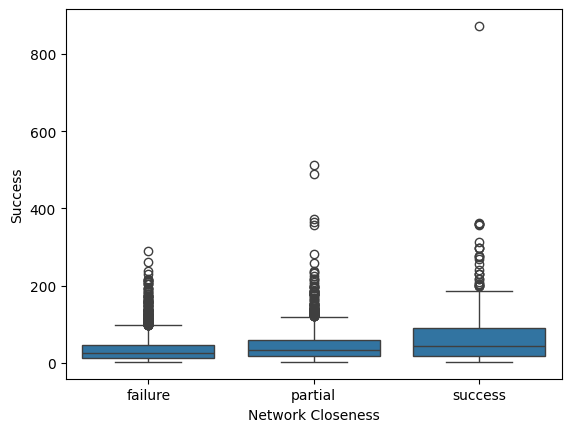

In [13]:
sns.boxplot(x='Success', y='num_connections', data=box_office_success_df)
plt.xlabel('Network Closeness')
plt.ylabel('Success')
plt.show()

In [14]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['num_connections']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['num_connections']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['num_connections']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

data = [failure, partial, success]
p_values = posthoc_dunn(data, p_adjust='bonferroni')

print("Matrix of pairwise p-values:")
print(p_values)

Kruskal-Wallis Test Statistic: 179.0775419219024
P-value: 1.2995884868995045e-39
There is a statistically significant difference between at least one pair of columns.
Matrix of pairwise p-values:
              1             2             3
1  1.000000e+00  3.131002e-20  2.507628e-31
2  3.131002e-20  1.000000e+00  1.364917e-08
3  2.507628e-31  1.364917e-08  1.000000e+00


As can be seen from the matrix of p-values for the comparison between number of connections in successful, partially successful, and failing movies, there is a significant difference between all pairs of the different groupings. Meaning, that the number of other characters that each character in a movie talks to has a significant effect on the success or failure of a movie, with the trend indicating that the more people each character interacts with in a movie, the more likely it is to be successful.

### The Effect of the Strength of a Movie Network on Movie Success

Success
failure     535.768530
partial     721.656669
success    1120.976780
Name: network_strength, dtype: float64


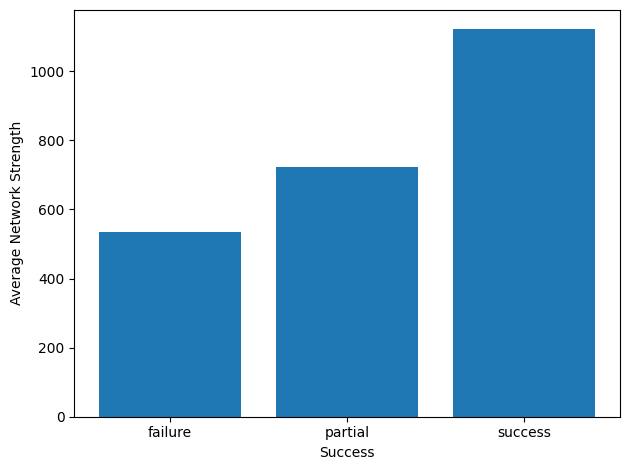

In [15]:
network_strength_df = box_office_success_df.groupby('Success')['network_strength'].mean()
print(network_strength_df)
plt.bar(network_strength_df.index, network_strength_df.values)

plt.xlabel('Success')
plt.ylabel('Average Network Strength')
plt.tight_layout()
plt.show()

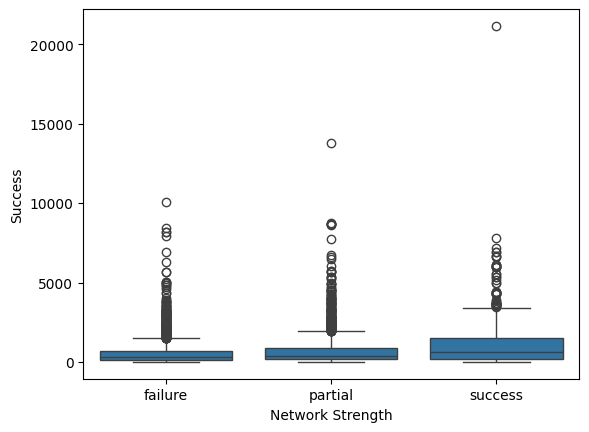

In [16]:
sns.boxplot(x='Success', y='network_strength', data=box_office_success_df)
plt.xlabel('Network Strength')
plt.ylabel('Success')
plt.show()

In [17]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['network_strength']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['network_strength']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['network_strength']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

data = [failure, partial, success]
p_values = posthoc_dunn(data, p_adjust='bonferroni')

print("Matrix of pairwise p-values:")
print(p_values)

Kruskal-Wallis Test Statistic: 176.65281622127736
P-value: 4.368459877141594e-39
There is a statistically significant difference between at least one pair of columns.
Matrix of pairwise p-values:
              1             2             3
1  1.000000e+00  2.728540e-20  1.191497e-30
2  2.728540e-20  1.000000e+00  3.109083e-08
3  1.191497e-30  3.109083e-08  1.000000e+00


The network strength is defined as the sum over all of the edge weights in the network. As can be seen from the matrix of p-values for the comparison between network strength in successful, partially successful, and failing movies, there is a significant difference between all pairs of the different groupings. Meaning, that the amount that each character talks to other characters and the number of other characters that he talks to has a significant effect on the success or failure of a movie, with the trend indicating that the more a character interacts with other charaters in a movie, both in amount of interaction and number of other characters, the more likely the movie is to be successful.

### The Effect of the Number of Main Characters on Movie Success

Success
failure    3.014277
partial    3.299132
success    3.580495
Name: num_main_characters, dtype: float64


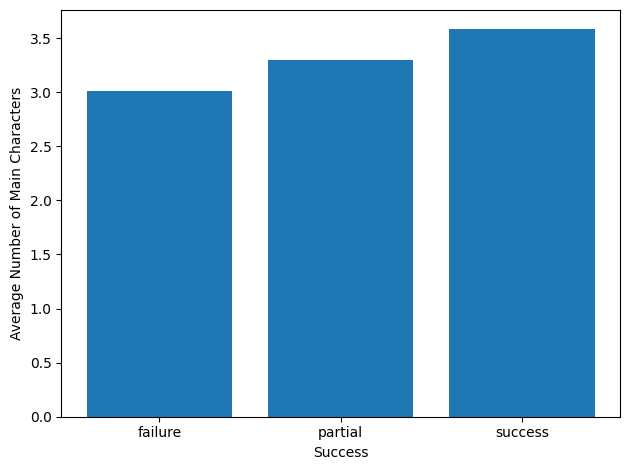

In [18]:
num_main_characters_df = box_office_success_df.groupby('Success')['num_main_characters'].mean()
print(num_main_characters_df)
plt.bar(num_main_characters_df.index, num_main_characters_df.values)

plt.xlabel('Success')
plt.ylabel('Average Number of Main Characters')
plt.tight_layout()
plt.show()

In [19]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['num_main_characters']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['num_main_characters']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['num_main_characters']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

data = [failure, partial, success]
p_values = posthoc_dunn(data, p_adjust='bonferroni')

print("Matrix of pairwise p-values:")
print(p_values)

Kruskal-Wallis Test Statistic: 37.25814700661503
P-value: 8.118880974372421e-09
There is a statistically significant difference between at least one pair of columns.
Matrix of pairwise p-values:
              1         2             3
1  1.000000e+00  0.000031  4.703587e-07
2  3.093001e-05  1.000000  3.988929e-02
3  4.703587e-07  0.039889  1.000000e+00


The main characters of the movie are defined as those who have a degree centrality greater than 0.6 after running a degree centrality algorithm over the movie network. Degree centrality states that a node with a higher degree (a character that speaks to a greater number of people) is more central to the network and thus has a higher centrality score. Therefore, a main character according to the social network of the movie (not according to the plot itself) is defined as one that has a high degree centrality score.

In this case, we can see that there are statistically significant differences between all groupings of movie success, indicating that the number of main characters in the movie affects the success of the movie. The higher number of main characters (nodes with higher degrees), the more successful the movie.

### The Effect of Max Number of Interactions

Success
failure     77.781288
partial     98.656275
success    117.749226
Name: max_weight_edge_value, dtype: float64


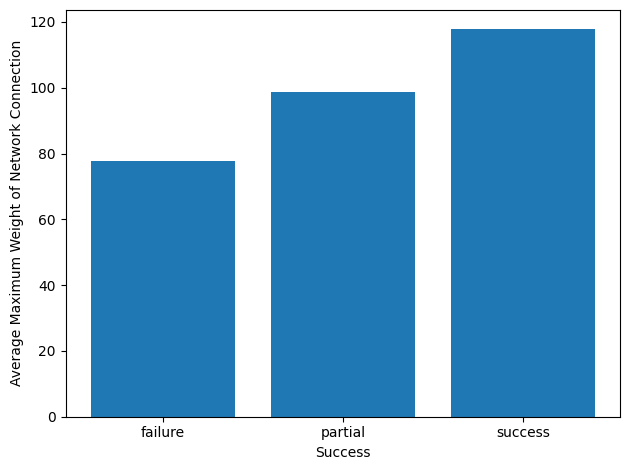

In [20]:
num_interactions_df = box_office_success_df.groupby('Success')['max_weight_edge_value'].mean()
print(num_interactions_df)
plt.bar(num_interactions_df.index, num_interactions_df.values)

plt.xlabel('Success')
plt.ylabel('Average Maximum Weight of Network Connection')
plt.tight_layout()
plt.show()

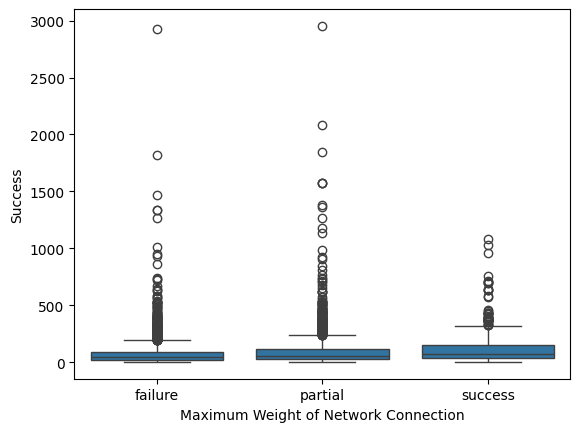

In [21]:
sns.boxplot(x='Success', y='max_weight_edge_value', data=box_office_success_df)
plt.xlabel('Maximum Weight of Network Connection')
plt.ylabel('Success')
plt.show()

In [22]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['max_weight_edge_value']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['max_weight_edge_value']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['max_weight_edge_value']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

data = [failure, partial, success]
p_values = posthoc_dunn(data, p_adjust='bonferroni')

print("Matrix of pairwise p-values:")
print(p_values)

Kruskal-Wallis Test Statistic: 117.71771545179357
P-value: 2.741087369747108e-26
There is a statistically significant difference between at least one pair of columns.
Matrix of pairwise p-values:
              1             2             3
1  1.000000e+00  1.756233e-14  2.729737e-20
2  1.756233e-14  1.000000e+00  2.651868e-05
3  2.729737e-20  2.651868e-05  1.000000e+00


The maximum weight of a network connection is defined as the maximum value of the weighted edges in the network, i.e. the number of interactions between the two characters who interacted the most during the movie. From the results of the analysis, we can see that there is statistical significance to this attribute, implying that as the number of interactions between the two characters who interacted the most increases, so does the success of the movie. However, we can see that there are many outliers with high maximum weights in both the failure and partial success categories, indicating that this single attribute is not enough to indicate success.

### Effect of Max Degree of Node on Movie Success

Success
failure    10.417375
partial    11.778216
success    14.671827
Name: max_degree_node_value, dtype: float64


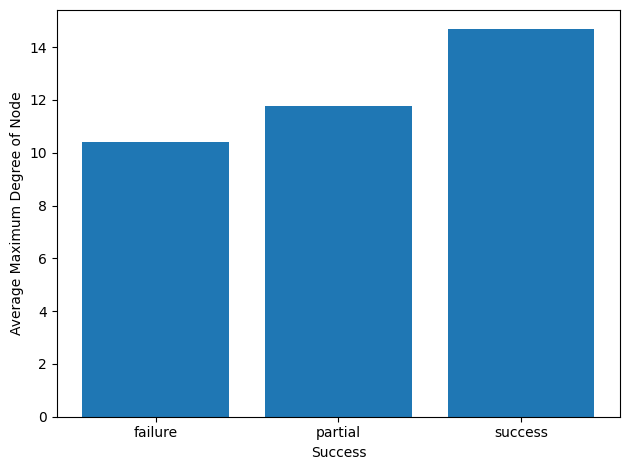

In [23]:
max_degree_df = box_office_success_df.groupby('Success')['max_degree_node_value'].mean()
print(max_degree_df)
plt.bar(max_degree_df.index, max_degree_df.values)

plt.xlabel('Success')
plt.ylabel('Average Maximum Degree of Node')
plt.tight_layout()
plt.show()

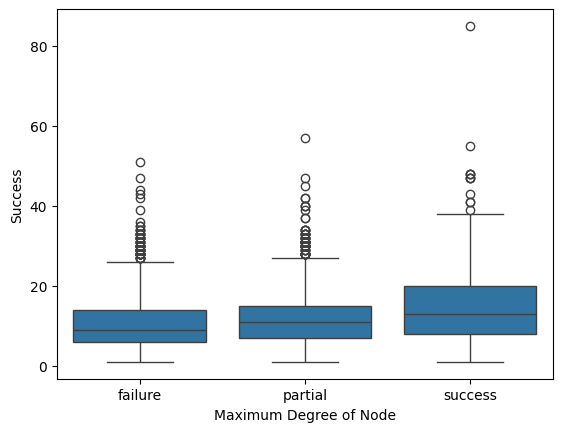

In [24]:
sns.boxplot(x='Success', y='max_degree_node_value', data=box_office_success_df)
plt.xlabel('Maximum Degree of Node')
plt.ylabel('Success')
plt.show()

In [25]:
failure = box_office_success_df[box_office_success_df['Success'] == 'failure']['max_degree_node_value']
partial = box_office_success_df[box_office_success_df['Success'] == 'partial']['max_degree_node_value']
success = box_office_success_df[box_office_success_df['Success'] == 'success']['max_degree_node_value']

statistic, p_value = kruskal(failure, partial, success)

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between at least one pair of columns.")
else:
    print("There is no statistically significant difference between the columns.")

data = [failure, partial, success]
p_values = posthoc_dunn(data, p_adjust='bonferroni')

print("Matrix of pairwise p-values:")
print(p_values)

Kruskal-Wallis Test Statistic: 162.36594985432055
P-value: 5.5294503734694276e-36
There is a statistically significant difference between at least one pair of columns.
Matrix of pairwise p-values:
              1             2             3
1  1.000000e+00  6.580388e-17  9.032912e-30
2  6.580388e-17  1.000000e+00  3.797805e-09
3  9.032912e-30  3.797805e-09  1.000000e+00


This attribute is the maximum degree that any node has in the network, or the number of other characters that the most social character in the network speaks with. From the result of the analysis, we can see that there is statistical significance to the effect of the maximum node degree in a movie network on the movie success, indicating that the more other characters that the most social character interacts with, the higher the success of the movie.

### General Conclusion from Individual Analyses

In general, according to these analyses, it seems that the more highly connected the social network and the more social the characters in the social network, the higher the likelihood of movie success. Meaning, the greater the number of characters, the more they interact with other characters, the higher the number of other characters they interact with, and the more the entire network of characters does this, the more successful the movie is at the box office and by review.

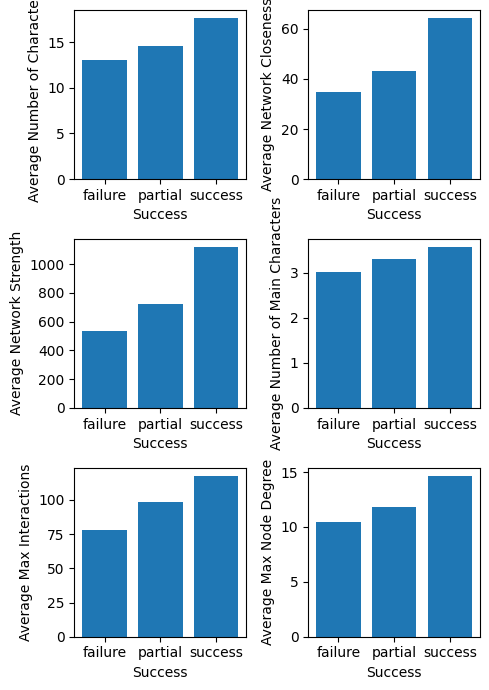

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(5, 7))

axes[0,0].bar(num_characters_df.index, num_characters_df.values)
axes[0,0].set_xlabel('Success')
axes[0,0].set_ylabel('Average Number of Characters')

axes[0,1].bar(num_edges_df.index, num_edges_df.values)
axes[0,1].set_xlabel('Success')
axes[0,1].set_ylabel('Average Network Closeness')

axes[1,0].bar(network_strength_df.index, network_strength_df.values)
axes[1,0].set_xlabel('Success')
axes[1,0].set_ylabel('Average Network Strength')

axes[1,1].bar(num_main_characters_df.index, num_main_characters_df.values)
axes[1,1].set_xlabel('Success')
axes[1,1].set_ylabel('Average Number of Main Characters')

axes[2,0].bar(num_interactions_df.index, num_interactions_df.values)
axes[2,0].set_xlabel('Success')
axes[2,0].set_ylabel('Average Max Interactions')

axes[2,1].bar(max_degree_df.index, max_degree_df.values)
axes[2,1].set_xlabel('Success')
axes[2,1].set_ylabel('Average Max Node Degree')

plt.tight_layout()
plt.show()

## Analysis of Effects of Combinations of Attributes on Movie Success

In order to do a multivariable analysis of the effects of a combination of variables on movie success, we need to encode the success variable numerically. The statistical tool chosen for this analysis is multiple linear regression which will analyze the effects of multiple independent variables on our dependent variable, movie success.

In [27]:
box_office_success_df['success_encoded'] = box_office_success_df['Success'].map({'failure': 0, 'partial': 1, 'success': 2})
box_office_success_df

,movie_name,year,num_characters,num_connections,num_connected_components,num_main_characters,max_degree_node_value,max_degree_node,network_strength,max_weight_edge_value,max_weight_edge_source,max_weight_edge_target,Budget,Revenue,Rating,Success,success_encoded
0,The Night Flier,1997,11,17,2,1,6,Richard Dees,235,59,Richard Dees,Katherine 'Jimmy' Blair,1000000,125397,6.0,failure,0
2,Final Destination 2,2003,16,58,1,5,14,Kimberly Corman,512,27,Kimberly Corman,Clear Rivers,26000000,90941129,6.2,partial,1
3,Resurrecting the Champ,2007,24,103,1,4,21,Bob Satterfield Jr.,1260,69,Bob Satterfield Jr.,Erik 'The Wow Man' Kernan Sr.,13000000,3243611,6.7,failure,0
4,John Wick: Chapter 2,2017,17,26,1,1,15,John Wick,313,73,John Wick,Santino D'Antonio,40000000,174348632,7.4,partial,1
5,Skyline,2010,7,13,1,4,5,Jarrod,207,57,Jarrod,Terry,10000000,66984887,4.5,partial,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12654,Snow Dogs,2002,16,30,1,2,12,Ted Brooks,256,29,Ted Brooks,James 'Thunder Jack' Johnson,33000000,115035090,5.2,partial,1
12656,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2,failure,0
12657,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2,failure,0
12658,"New York, I Love You",2008,4,4,1,3,3,"David Cooler (segment ""Shunji Iwai"")",29,19,"Camille (segment ""Shunji Iwai"")","David Cooler (segment ""Shunji Iwai"")",14700000,9961023,6.2,failure,0


### Effects of Network Connections on Movie Success

We define network connections as those attributes having to do with the entire network. In this case, those attributes are the number of characters, network closeness, and network strength. In this section, we analyze the combined effects of network connections on movie success.

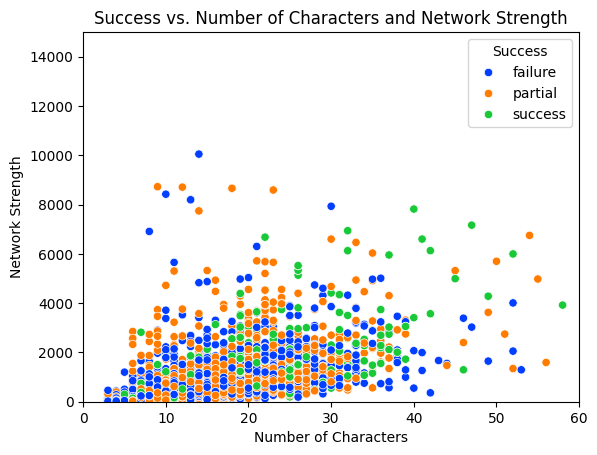

In [28]:
sns.scatterplot(data=box_office_success_df, x='num_characters', y='network_strength', hue='Success', palette='bright')
plt.xlabel('Number of Characters')
plt.ylabel('Network Strength')
plt.title('Success vs. Number of Characters and Network Strength')

plt.xlim(0, 60)
plt.ylim(0, 15000)
plt.show()

In [29]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = box_office_success_df[['num_characters', 'network_strength']]
y = box_office_success_df[['success_encoded']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        success_encoded   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     132.3
Date:                Mon, 06 May 2024   Prob (F-statistic):           4.92e-57
Time:                        14:05:04   Log-Likelihood:                -6406.6
No. Observations:                6472   AIC:                         1.282e+04
Df Residuals:                    6469   BIC:                         1.284e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3999      0.018  

In [30]:
correlation = box_office_success_df[['num_characters', 'network_strength']].corr()

print("Correlation Matrix:")
print(correlation)

print("\nCorrelation Coefficient between 'num_characters' and 'network_strength':")
print(correlation.loc['num_characters', 'network_strength'])

Correlation Matrix:
                  num_characters  network_strength
num_characters          1.000000          0.599971
network_strength        0.599971          1.000000

Correlation Coefficient between 'num_characters' and 'network_strength':
0.5999713989405576


The correlation coefficient of 0.6 between the number of characters and network strength indicates a strong positive linear correlation between these two variables. Meaning, that as the number of characters increases, the strength of the network increases.

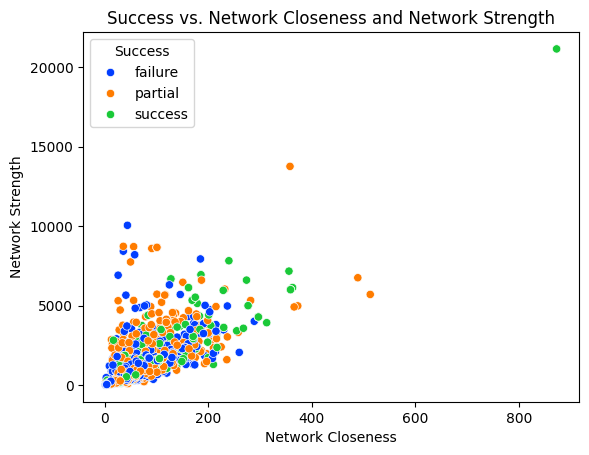

In [31]:
sns.scatterplot(data=box_office_success_df, x='num_connections', y='network_strength', hue='Success', palette='bright')
plt.xlabel('Network Closeness')
plt.ylabel('Network Strength')
plt.title('Success vs. Network Closeness and Network Strength')

plt.show()

In [32]:
X = box_office_success_df[['num_connections', 'network_strength']]
y = box_office_success_df[['success_encoded']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        success_encoded   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     137.4
Date:                Mon, 06 May 2024   Prob (F-statistic):           3.78e-59
Time:                        14:05:04   Log-Likelihood:                -6401.8
No. Observations:                6472   AIC:                         1.281e+04
Df Residuals:                    6469   BIC:                         1.283e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4631      0.011  

In [33]:
correlation = box_office_success_df[['num_connections', 'network_strength']].corr()

print("Correlation Matrix:")
print(correlation)

print("\nCorrelation Coefficient between 'num_connections' and 'network_strength':")
print(correlation.loc['num_connections', 'network_strength'])

Correlation Matrix:
                  num_connections  network_strength
num_connections          1.000000          0.777787
network_strength         0.777787          1.000000

Correlation Coefficient between 'num_connections' and 'network_strength':
0.7777874153156537


In the case of network closeness (number of edges) and network strength, we see that these variables are even more closely correlated with a correlation coefficient of 0.78. Meaning, that as the number of other characters one character interacts with increases, so does the strength of the network, i.e. the total number of interactions between characters.

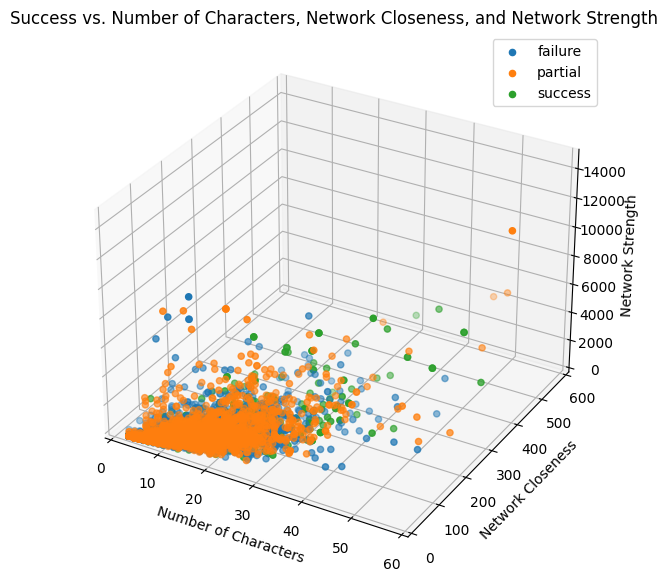

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for s in box_office_success_df['Success'].unique():
    ax.scatter(box_office_success_df.num_characters[box_office_success_df.Success==s],box_office_success_df.num_connections[box_office_success_df.Success==s],box_office_success_df.network_strength[box_office_success_df.Success==s],label=s)

ax.set_xlabel('Number of Characters')
ax.set_ylabel('Network Closeness')
ax.set_zlabel('Network Strength')
ax.set_title('Success vs. Number of Characters, Network Closeness, and Network Strength')

plt.xlim(0, 60)
plt.ylim(0, 600)
ax.set_zlim(0, 15000)

ax.legend()
plt.show()

In [35]:
X = box_office_success_df[['num_characters', 'num_connections', 'network_strength']]
y = box_office_success_df[['success_encoded']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        success_encoded   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     92.05
Date:                Mon, 06 May 2024   Prob (F-statistic):           2.50e-58
Time:                        14:05:05   Log-Likelihood:                -6401.1
No. Observations:                6472   AIC:                         1.281e+04
Df Residuals:                    6468   BIC:                         1.284e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4413      0.022  

From the combined analysis of the effect of number of characters, network closeness, and network strength, we can see that only two of the three variables have a significant impact on the movie success outcome. Because the p-value for number of characters is greater than 0.05, and the p-values for network closeness and network strength are both less than 0.05, we can conclude that only network closeness and network strength have a statistically significant effect on the success of a movie.

However, as shown with the previous analysis, there is colinearity between these independent variables, which can affect the outcome. This is logical because an increased number of characters allows for an increased number of edges (network closeness) which in turn allows for an increased network strength. Therefore, when looking for factors to predict movie success, both the number of characters each character interacts with and the amount of interaction they have with these other characters are more significant predictors of movie success than the number of characters that appear in the movie.

### Effects of Social Dynamics of the Social Network on Movie Success

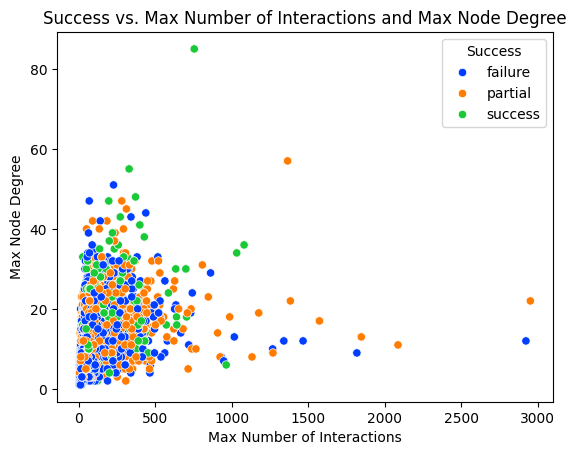

In [36]:
sns.scatterplot(data=box_office_success_df, x='max_weight_edge_value', y='max_degree_node_value', hue='Success', palette='bright')
plt.xlabel('Max Number of Interactions')
plt.ylabel('Max Node Degree')
plt.title('Success vs. Max Number of Interactions and Max Node Degree')
plt.show()

In [37]:
X = box_office_success_df[['max_weight_edge_value', 'max_degree_node_value']]
y = box_office_success_df[['success_encoded']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        success_encoded   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     115.7
Date:                Mon, 06 May 2024   Prob (F-statistic):           4.29e-50
Time:                        14:05:06   Log-Likelihood:                -6422.6
No. Observations:                6472   AIC:                         1.285e+04
Df Residuals:                    6469   BIC:                         1.287e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.38

Both the maximum number of interactions and the maximum node degree have p-values of less than 0.05, indicating that there is a statistical significance to their effect on the success of a movie when looking at the combination of their effects. Because the coefficient of the maximum number of interactions is less than the coefficient of the maximum node degree, we can conclude that the number of other characters the most social character interacts with has more of an influence on the success of a movie than the number of interactions between the two characters who interact the most in a movie.

If we look at the scatterplot, it also seems as if the successful movies have a limit to the maximum number of interactions of around 1000, with only partially successful and failing movies having edge weights above this. Similarly, from the graph we can see the trend we saw in the individual analyses in that the more successful movies seem to have higher maximum node degrees.

In addition, the number of connected components was added to this analysis, but there was no significant effect found of the number of connected components (social circles) in a movie's social network on the success of a movie.

### Effects of All Attributes on Movie Success

In [38]:
X = box_office_success_df[['num_main_characters', 'network_strength', 'max_weight_edge_value', 'max_degree_node_value']]
y = box_office_success_df[['success_encoded']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:        success_encoded   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     66.86
Date:                Mon, 06 May 2024   Prob (F-statistic):           1.62e-55
Time:                        14:05:06   Log-Likelihood:                -6405.2
No. Observations:                6472   AIC:                         1.282e+04
Df Residuals:                    6467   BIC:                         1.285e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.42

Because of the multicollinearity of network strength, network closeness, and number of characters in a network, only one of these attributes, the network strength was chosen in the analysis of the effect of all of the attributes together on the movie success. In addition, the attribute of the number of connected components was removed because it had no significant effect on the success of the movie even individually. The attributes remaining that were analyzed together were: network strength, number of main characters, maximum edge weight, and maximum node degree.

When analyzing the p-values of these attributes, and thus the significance of their effect on the outcome, we can see that the network strength, maximum edge weight, and maximum node degree all have p-values of less than 0.05 while the number of main characters does not seem to have a significant impact on the outcome.

Thus, we can conclude that the three attributes of network strength, maximum edge weight, and maximum node degree have a significant impact on the success of a movie at the box office and in review, and if movie producers wished to increase the likelihood of the success of their movies, they would do well to look at these three attributes and their impact.